Last updated: June 29th 2016

# Climate data exploration: a journey through Pandas

Welcome to a demo of Python's data analysis package called `Pandas`. Our goal is to learn about Data Analysis and transformation using Pandas while exploring datasets used to analyze climate change. 

## The story

The global goal of this demo is to provide the tools to be able to try and reproduce some of the analysis done in the IPCC global climate reports published in the last decade (see for example https://www.ipcc.ch/pdf/assessment-report/ar5/syr/SYR_AR5_FINAL_full.pdf). 

We are first going to load a few public datasets containing information about global temperature, global and local sea level infomation, and global concentration of greenhouse gases like CO2, to see if there are correlations and how the trends are to evolve, assuming no fundamental change in the system. For all these datasets, we will download them, visualize them, clean them, search through them, merge them, resample them, transform them and summarize them.

In the process, we will learn about:

Part 1:

    1. Loading data
    2. Pandas datastructures
    3. Cleaning and formatting data
    4. Basic visualization
   
Part 2:

    5. Accessing data
    6. Working with dates and times
    7. Transforming datasets
    8. Statistical analysis
    9. Data agregation and summarization
    10. Correlations and regressions
    11. Predictions from auto regression models

## Some initial setup

In [1]:
%matplotlib inline
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 16)

LARGE_FIGSIZE = (12, 8)

In [2]:
# Change this cell to the demo location on YOUR machine
%cd ~/Data_Science/pandas_tutorial/climate_timeseries/
%ls

/Users/dbalduini/Data_Science/pandas_tutorial/climate_timeseries
all_data.h5                     data/
climate_timeseries-Part1.ipynb  giss_temp-export.csv
climate_timeseries-Part2.ipynb  sandbox/


## Reloading data

In [3]:
with pd.HDFStore("all_data.h5") as store:
    giss_temp = store["/temperatures/giss"]
    full_globe_temp = store["/temperatures/full_globe"]
    mean_sea_level = store["/sea_level/mean_sea_level"]
    local_sea_level_stations = store["/sea_level/stations"]

## 5. Accessing data

The general philosophy for accessing values inside a Pandas datastructure is that, unlike a numpy array that only allows to index using integers a Series allows to index with the values inside the index. That makes the code more readable.

### In a series

In [4]:
full_globe_temp

year
1880-01-01   -0.1591
1881-01-01   -0.0789
1882-01-01   -0.1313
1883-01-01   -0.1675
1884-01-01   -0.2485
1885-01-01   -0.2042
1886-01-01   -0.1695
1887-01-01   -0.2505
               ...  
2003-01-01    0.5818
2004-01-01    0.5416
2005-01-01    0.6154
2006-01-01    0.5601
2007-01-01    0.5472
2008-01-01    0.4804
2009-01-01    0.5551
2010-01-01       NaN
Name: mean temp, dtype: float64

In [ ]:
# By default [] on a series accesses values using the index, not the location in the series

In [5]:
# This index is non-trivial though (will talk more about these datetime objects further down):
full_globe_temp.index.dtype

dtype('<M8[ns]')

In [6]:
first_date = full_globe_temp.index[0]
first_date == pd.to_datetime('1880')

True

In [7]:
# By default [] on a series accesses values using the index, not the location in the series
print(full_globe_temp[pd.to_datetime('1880')])
# print(temp1[0])  # This would fail!!

-0.1591


In [8]:
# Another more explicit way to do the same thing is to use loc
print(full_globe_temp.loc[pd.to_datetime('1990')])
print(full_globe_temp.iloc[0], full_globe_temp.iloc[-1])

0.3861
-0.1591 nan


In [9]:
# Year of the last record?
full_globe_temp.index[-1]

Timestamp('2010-01-01 00:00:00')

In [10]:
# New records can be added:
full_globe_temp[pd.to_datetime('2011')] = np.nan

### In a dataframe

In [11]:
# In 2D, same idea, though in a DF [] accesses columns (Series)
giss_temp["Jan"]

Year
1880   -34.0
1881   -13.0
1882     3.0
1883   -38.0
1884   -20.0
1885   -57.0
1886   -37.0
1887   -60.0
        ... 
2008    22.0
2009    56.0
2010    66.0
2011    45.0
2012    38.0
2013    62.0
2014    68.0
2015    75.0
Name: Jan, dtype: float32

In [12]:
# while .loc and .iloc allow to access individual values, slices or masked selections:
print(giss_temp.loc[1979, "Dec"])

43.0


In [14]:
# the loc operators support fancy indexing:
print(giss_temp.loc[1979, ["Nov", "Dec"]])

Nov    24.0
Dec    43.0
Name: 1979, dtype: float32


In [15]:
# Slicing can be done with .loc and .iloc
print(giss_temp.loc[1979, "Jan":"Jun"])  # Note that the end point is included unlike NumPy!!!
print(giss_temp.loc[1979, ::2])

Jan    10.0
Feb   -12.0
Mar    14.0
Apr     8.0
May     1.0
Jun     9.0
Name: 1979, dtype: float32
Jan    10.0
Mar    14.0
May     1.0
Jul    -3.0
Sep    20.0
Nov    24.0
Name: 1979, dtype: float32


In [16]:
# Masking can also be used in one or more dimensions. For example, another way to grab every other month for the first year:
mask = [True, False] * 6
print(giss_temp.iloc[0, mask])
print(giss_temp.loc[1880, mask])

Jan   -34.0
Mar   -22.0
May   -16.0
Jul   -19.0
Sep   -20.0
Nov   -16.0
Name: 1880, dtype: float32
Jan   -34.0
Mar   -22.0
May   -16.0
Jul   -19.0
Sep   -20.0
Nov   -16.0
Name: 1880, dtype: float32


In [18]:
# We could also add a new column like a new entry in a dictionary
giss_temp["totals"] = giss_temp.sum(axis=1)
giss_temp

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,totals
Year,,,,,,,,,,,,,
1880,-34.0,-27.0,-22.0,-30.0,-16.0,-24.0,-19.0,-12.0,-20.0,-19.0,-16.0,-21.0,-520.0
1881,-13.0,-16.0,-2.0,-3.0,-3.0,-27.0,-12.0,-8.0,-18.0,-23.0,-28.0,-18.0,-342.0
1882,3.0,4.0,-2.0,-24.0,-20.0,-32.0,-27.0,-11.0,-11.0,-25.0,-25.0,-37.0,-414.0
1883,-38.0,-38.0,-12.0,-20.0,-20.0,-8.0,-3.0,-13.0,-19.0,-19.0,-28.0,-21.0,-478.0
1884,-20.0,-14.0,-31.0,-36.0,-33.0,-36.0,-31.0,-24.0,-29.0,-25.0,-29.0,-25.0,-666.0
1885,-57.0,-29.0,-19.0,-36.0,-35.0,-40.0,-28.0,-24.0,-17.0,-14.0,-14.0,0.0,-626.0
1886,-37.0,-43.0,-34.0,-23.0,-21.0,-30.0,-13.0,-21.0,-12.0,-22.0,-29.0,-18.0,-606.0
1887,-60.0,-43.0,-26.0,-34.0,-28.0,-25.0,-19.0,-28.0,-24.0,-33.0,-29.0,-40.0,-778.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [19]:
# Let's remove this new column, we will learn to do this differently
giss_temp = giss_temp.drop("totals", axis=1)

More complex queries rely on the same concepts. For example what are the names, and IDs of the sea level stations in the USA?

In [20]:
local_sea_level_stations.columns

Index(['Station Name', 'ID', 'Lat', 'Lon', 'GLOSS ID', 'Country', 'Date',
       'Coastline', 'Station'],
      dtype='object')

In [24]:
american_stations = local_sea_level_stations["Country"] == "USA"

local_sea_level_stations.loc[american_stations, ["ID", "Station Name"]]

,ID,Station Name
1287,1372,FRENCH FRIGATE SHOALS
1288,2192,FRENCH FRIGATE SHOALS B
1289,2129,"PORT ALLEN, HANAPEPE BAY, KAUAI ISLAND"
1290,756,"NAWILIWILI BAY, KAUAI ISLAND"
1291,155,HONOLULU
1292,823,MOKUOLOE ISLAND
1293,2273,"LANAI ISLAND, KAUMALAPAU"
1294,521,"KAHULUI HARBOR, MAUI ISLAND"
...,...,...
1457,288,SEAVEY ISLAND


**EXERCISE**: Print all European countries that have sea level stations. We will for now define Europe as being a country that has a station within the 30-70 latitude and a longitude in -10 to 40. You will need to combine masks using the `&` (`and`) and/or the `|` (`or`) operators, just like in Numpy.

Bonus: print each country only once.

In [26]:
local_sea_level_stations.head()

,Station Name,ID,Lat,Lon,GLOSS ID,Country,Date,Coastline,Station
0,HELIGMAN,231,60.200,19.300,NaN,ALA,01/01/1980,60,251
1,KOBBAKLINTAR,63,60.033,19.883,NaN,ALA,01/01/1980,60,261
2,LEMSTROM,84,60.100,20.017,NaN,ALA,01/01/1980,60,271
3,FOGLO / DEGERBY,249,60.032,20.385,NaN,ALA,06/10/2015,60,281
4,PAGO PAGO,539,-14.280,-170.690,144.0,ASM,08/03/2016,745,1


In [49]:
eu_lat_mask = (local_sea_level_stations.Lat > 30) & (local_sea_level_stations.Lat < 70)

In [50]:
eu_lon_mask = (local_sea_level_stations.Lon > -10) & (local_sea_level_stations.Lon < 40)

In [51]:
np.unique(local_sea_level_stations.loc[eu_lat_mask & eu_lon_mask, "Country"])

array(['ALA', 'BEL', 'BGR', 'CYP', 'DEU', 'DNK', 'EGY', 'ESP', 'EST',
       'FIN', 'FRA', 'FRO', 'GBR', 'GIB', 'GRC', 'HRV', 'IMN', 'IRL',
       'ISR', 'ITA', 'JEY', 'LTU', 'LVA', 'MAR', 'MCO', 'MLT', 'MNE',
       'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SVN', 'SWE', 'TUR', 'UKR'], dtype=object)

## Warning: modifying a dataframe with multiple indexing

In [52]:
giss_temp

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1880,-34.0,-27.0,-22.0,-30.0,-16.0,-24.0,-19.0,-12.0,-20.0,-19.0,-16.0,-21.0
1881,-13.0,-16.0,-2.0,-3.0,-3.0,-27.0,-12.0,-8.0,-18.0,-23.0,-28.0,-18.0
1882,3.0,4.0,-2.0,-24.0,-20.0,-32.0,-27.0,-11.0,-11.0,-25.0,-25.0,-37.0
1883,-38.0,-38.0,-12.0,-20.0,-20.0,-8.0,-3.0,-13.0,-19.0,-19.0,-28.0,-21.0
1884,-20.0,-14.0,-31.0,-36.0,-33.0,-36.0,-31.0,-24.0,-29.0,-25.0,-29.0,-25.0
1885,-57.0,-29.0,-19.0,-36.0,-35.0,-40.0,-28.0,-24.0,-17.0,-14.0,-14.0,0.0
1886,-37.0,-43.0,-34.0,-23.0,-21.0,-30.0,-13.0,-21.0,-12.0,-22.0,-29.0,-18.0
1887,-60.0,-43.0,-26.0,-34.0,-28.0,-25.0,-19.0,-28.0,-24.0,-33.0,-29.0,-40.0
...,...,...,...,...,...,...,...,...,...,...,...,...


In [56]:
print(type(giss_temp['Jan']))
print(type(giss_temp[['Jan']]))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [57]:
giss_temp['Jan']

Year
1880   -34.0
1881   -13.0
1882     3.0
1883   -38.0
1884   -20.0
1885   -57.0
1886   -37.0
1887   -60.0
        ... 
2008    22.0
2009    56.0
2010    66.0
2011    45.0
2012    38.0
2013    62.0
2014    68.0
2015    75.0
Name: Jan, dtype: float32

In [58]:
giss_temp[['Jan']]

,Jan
Year,
1880,-34.0
1881,-13.0
1882,3.0
1883,-38.0
1884,-20.0
1885,-57.0
1886,-37.0
1887,-60.0
...,...


In [ ]:
# This works right now, but this is dangerous:
#giss_temp['Jan'][1880] = -33.9

In [ ]:
#giss_temp

In [ ]:
# This is the safe way to do it:
#giss_temp.loc[1880, 'Jan'] = -33.9

## 6. Working with dates and times

More details at http://pandas.pydata.org/pandas-docs/stable/timeseries.html

Let's work some more with `full_globe_temp`'s index since we saw it is special.

In [59]:
# Its dtype is NumPy's new 'datetime64[ns]':
full_globe_temp.index.dtype

dtype('<M8[ns]')

The advantage of having a real datetime index is that operations can be done efficiently on it. Let's add a flag to signal if the value is before or after the great depression's black Friday:

In [60]:
black_friday = pd.to_datetime('1929-10-29')
full_globe_temp.index > black_friday

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

### Timestamps or periods?

In [61]:
# Convert its index from timestamp to period: it is more meaningfull since it was measured and averaged over the year...
full_globe_temp.index = full_globe_temp.index.to_period()
full_globe_temp

year
1880   -0.1591
1881   -0.0789
1882   -0.1313
1883   -0.1675
1884   -0.2485
1885   -0.2042
1886   -0.1695
1887   -0.2505
         ...  
2004    0.5416
2005    0.6154
2006    0.5601
2007    0.5472
2008    0.4804
2009    0.5551
2010       NaN
2011       NaN
Freq: A-DEC, Name: mean temp, dtype: float64

See also `to_timestamp` to conver back to timestamps and its `how` method to specify when inside the range to set the timestamp.

### Resampling

Another thing that can be done is to resample the series, downsample or upsample. Let's see the series converted to 10 year blocks or upscale to a monthly series:

In [62]:
# Frequencies can be specified as strings: "us", "ms", "S", "T", "H", "D", "B", "W", "M", "A", "3min", "2h20", ...
# More aliases at http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
full_globe_temp.resample("M").mean()

year
1880-01   -0.1591
1880-02       NaN
1880-03       NaN
1880-04       NaN
1880-05       NaN
1880-06       NaN
1880-07       NaN
1880-08       NaN
            ...  
2011-05       NaN
2011-06       NaN
2011-07       NaN
2011-08       NaN
2011-09       NaN
2011-10       NaN
2011-11       NaN
2011-12       NaN
Freq: M, Name: mean temp, dtype: float64

In [63]:
full_globe_temp.resample("10A").mean()

year
1880-12-31   -0.15910
1890-12-31   -0.18226
1900-12-31   -0.21054
1910-12-31   -0.31381
1920-12-31   -0.25518
1930-12-31   -0.13395
1940-12-31    0.00786
1950-12-31    0.04548
1960-12-31   -0.00198
1970-12-31    0.02566
1980-12-31    0.04817
1990-12-31    0.21491
2000-12-31    0.36288
2010-12-31    0.55260
2020-12-31        NaN
Freq: 10A-DEC, Name: mean temp, dtype: float64

### Generating DatetimeIndex objects

The index for `giss_temp` isn't an instance of datetimes so we may want to generate such `DatetimeIndex` objects. This can be done with `date_range` and `period_range`:

In [64]:
# Can specify a start date and a number of values desired. By default it will assume an interval of 1 day:
pd.date_range('1/1/1880', periods=4)

DatetimeIndex(['1880-01-01', '1880-01-02', '1880-01-03', '1880-01-04'], dtype='datetime64[ns]', freq='D')

In [65]:
# Can also specify a start and a stop date, as well as a frequency
pd.date_range('1/1/1880', '1/1/2016', freq="A")

DatetimeIndex(['1880-12-31', '1881-12-31', '1882-12-31', '1883-12-31',
               '1884-12-31', '1885-12-31', '1886-12-31', '1887-12-31',
               '1888-12-31', '1889-12-31',
               ...
               '2006-12-31', '2007-12-31', '2008-12-31', '2009-12-31',
               '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31',
               '2014-12-31', '2015-12-31'],
              dtype='datetime64[ns]', length=136, freq='A-DEC')

Note that `"A"` by default means the end of the year. Other times in the year can be specified with `"AS"` (start), `"A-JAN"` or `"A-JUN"`. Even more options can be imported from `pandas.tseries.offsets`:

In [66]:
from pandas.tseries.offsets import YearBegin
pd.date_range('1/1/1880', '1/1/2015', freq=YearBegin())

DatetimeIndex(['1880-01-01', '1881-01-01', '1882-01-01', '1883-01-01',
               '1884-01-01', '1885-01-01', '1886-01-01', '1887-01-01',
               '1888-01-01', '1889-01-01',
               ...
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01'],
              dtype='datetime64[ns]', length=136, freq='AS-JAN')

Actually we will convert that dataset to a 1D dataset, and build a monthly index, so lets build a monthly period index

In [67]:
giss_temp_index = pd.period_range('1/1/1880', '12/1/2015', freq="M")
giss_temp_index

PeriodIndex(['1880-01', '1880-02', '1880-03', '1880-04', '1880-05', '1880-06',
             '1880-07', '1880-08', '1880-09', '1880-10',
             ...
             '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08',
             '2015-09', '2015-10', '2015-11', '2015-12'],
            dtype='int64', length=1632, freq='M')

## 7. Transforming datasets: apply, sort, stack/unstack and transpose

Let's look at our `local_sea_level_stations` dataset some more, to learn more about it and also do some formatting. What is the range of dates and lattitudes we have, the list of countries, the range of variations, ...

In [70]:
# What about the range of dates?
print(
    local_sea_level_stations["Date"].min(),
    local_sea_level_stations["Date"].max(),
    local_sea_level_stations["Date"].iloc[-1]
)

01/01/1980 31/07/2014 01/02/2016


In [71]:
local_sea_level_stations.dtypes

Station Name     object
ID                int64
Lat             float64
Lon             float64
GLOSS ID        float64
Country          object
Date             object
Coastline         int64
Station           int64
dtype: object

### Apply: transforming Series

We don't see the range of dates because the dates are of dtype "Object", (usually meaning strings). Let's convert that using `apply`:

In [72]:
local_sea_level_stations["Date"].apply(pd.to_datetime)

0      1980-01-01
1      1980-01-01
2      1980-01-01
3      2015-06-10
4      2016-08-03
5      1999-11-05
6      2015-05-21
7      2004-09-30
          ...    
1478   2015-11-17
1479   2015-11-17
1480   2015-11-17
1481   2016-08-03
1482   2016-08-03
1483   2016-09-03
1484   2016-09-03
1485   2016-01-02
Name: Date, dtype: datetime64[ns]

This `apply` method is very powerful and general. We have used it to do something we could have done with `astype`, but any custom function can be provided to `apply`.

In [73]:
local_sea_level_stations["Date"] = local_sea_level_stations["Date"].apply(pd.to_datetime)

# Now we can really compare the dates, and therefore get a real range:
print(local_sea_level_stations["Date"].min(), local_sea_level_stations["Date"].max())

1980-01-01 00:00:00 2016-12-13 00:00:00


**EXERCISE:** Use the `apply` method to search through the stations names for a station in New York. What is the ID of the station?

In [ ]:
# Your code here

Now that we know the range of dates, to look at the data, sorting it following the dates is done with `sort`:

In [74]:
local_sea_level_stations.sort_values(by="Date")

,Station Name,ID,Lat,Lon,GLOSS ID,Country,Date,Coastline,Station
0,HELIGMAN,231,60.200,19.300,NaN,ALA,1980-01-01,60,251
151,BELLA COOLA,1084,52.367,-126.783,NaN,CAN,1980-01-01,822,13
633,KURE III,1023,34.233,132.550,NaN,JPN,1980-01-01,643,42
632,KURE II,749,34.233,132.533,NaN,JPN,1980-01-01,643,41
154,ALERT BAY,554,50.583,-126.950,NaN,CAN,1980-01-01,822,21
619,TOBA,627,34.467,136.850,NaN,JPN,1980-01-01,642,134
156,COMOX,630,49.667,-124.917,NaN,CAN,1980-01-01,822,31
607,ITO I,876,34.967,139.117,NaN,JPN,1980-01-01,642,111
...,...,...,...,...,...,...,...,...,...
251,PUNTA ARENAS II,2263,-53.124,-70.860,NaN,CHL,2016-12-10,850,62


Since many stations last updated on the same dates, it is logical to want to sort further, for example, by `Country` at constant date:

In [75]:
local_sea_level_stations.sort_values(by=["Date", "Country"], ascending=False)

,Station Name,ID,Lat,Lon,GLOSS ID,Country,Date,Coastline,Station
914,SAN JOSE,1711,12.333,121.083,NaN,PHL,2016-12-13,660,2
238,IQUIQUE II,2261,-20.204,-70.148,NaN,CHL,2016-12-10,850,7
240,ANTOFAGASTA 2,510,-23.653,-70.404,174.0,CHL,2016-12-10,850,12
241,SAN FELIX,1751,-26.292,-80.109,177.0,CHL,2016-12-10,850,16
243,VALPARAISO,499,-33.027,-71.626,175.0,CHL,2016-12-10,850,31
244,JUAN FERNANDEZ-C,1644,-33.636,-78.830,176.0,CHL,2016-12-10,850,39
247,CORRAL II,2262,-39.878,-73.423,NaN,CHL,2016-12-10,850,48
248,ANCUD,2264,-41.867,-73.832,NaN,CHL,2016-12-10,850,53
...,...,...,...,...,...,...,...,...,...
17,PIRAMIDE,867,-42.583,-64.283,NaN,ARG,1980-01-01,860,41


### Stack and unstack

Let's look at the GISS dataset differently. Instead of seeing the months along the axis 1, and the years along the axis 0, it would could be good to convert these into an outer and an inner axis along only 1 time dimension.

Stacking and unstacking allows to convert a dataframe into a series and vice-versa:

In [76]:
giss_temp.unstack?

In [77]:
unstacked = giss_temp.unstack()
unstacked

     Year
Jan  1880   -34.0
     1881   -13.0
     1882     3.0
     1883   -38.0
     1884   -20.0
     1885   -57.0
     1886   -37.0
     1887   -60.0
             ... 
Dec  2008    51.0
     2009    58.0
     2010    44.0
     2011    48.0
     2012    46.0
     2013    61.0
     2014    74.0
     2015     NaN
dtype: float32

In [78]:
# Note the nature of the result:
type(unstacked)

pandas.core.series.Series

The result is grouped in the wrong order since it sorts first the axis that was unstacked. Another transformation that would help us is transposing...

In [79]:
giss_temp.transpose()

Year,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Jan,-34.0,-13.0,3.0,-38.0,-20.0,-57.0,-37.0,-60.0,-43.0,-18.0,...,52.0,93.0,22.0,56.0,66.0,45.0,38.0,62.0,68.0,75.0
Feb,-27.0,-16.0,4.0,-38.0,-14.0,-29.0,-43.0,-43.0,-41.0,16.0,...,65.0,65.0,31.0,48.0,75.0,44.0,43.0,52.0,44.0,80.0
Mar,-22.0,-2.0,-2.0,-12.0,-31.0,-19.0,-34.0,-26.0,-39.0,6.0,...,59.0,67.0,70.0,49.0,87.0,57.0,52.0,60.0,71.0,84.0
Apr,-30.0,-3.0,-24.0,-20.0,-36.0,-36.0,-23.0,-34.0,-25.0,7.0,...,45.0,71.0,48.0,57.0,82.0,60.0,62.0,48.0,72.0,71.0
May,-16.0,-3.0,-20.0,-20.0,-33.0,-35.0,-21.0,-28.0,-26.0,-1.0,...,43.0,64.0,46.0,59.0,71.0,47.0,71.0,56.0,79.0,NaN
Jun,-24.0,-27.0,-32.0,-8.0,-36.0,-40.0,-30.0,-25.0,-20.0,-10.0,...,60.0,55.0,43.0,62.0,60.0,54.0,59.0,61.0,62.0,NaN
Jul,-19.0,-12.0,-27.0,-3.0,-31.0,-28.0,-13.0,-19.0,-11.0,-13.0,...,50.0,58.0,54.0,66.0,56.0,70.0,50.0,53.0,50.0,NaN
Aug,-12.0,-8.0,-11.0,-13.0,-24.0,-24.0,-21.0,-28.0,-13.0,-18.0,...,66.0,57.0,39.0,61.0,59.0,69.0,56.0,61.0,74.0,NaN
Sep,-20.0,-18.0,-11.0,-19.0,-29.0,-17.0,-12.0,-24.0,-10.0,-18.0,...,59.0,61.0,59.0,64.0,55.0,52.0,68.0,73.0,81.0,NaN
Oct,-19.0,-23.0,-25.0,-19.0,-25.0,-14.0,-22.0,-33.0,-3.0,-21.0,...,66.0,56.0,62.0,58.0,65.0,60.0,73.0,61.0,78.0,NaN


In [80]:
giss_temp_series = giss_temp.transpose().unstack()
giss_temp_series.name = "Temp anomaly"
giss_temp_series

Year     
1880  Jan   -34.0
      Feb   -27.0
      Mar   -22.0
      Apr   -30.0
      May   -16.0
      Jun   -24.0
      Jul   -19.0
      Aug   -12.0
             ... 
2015  May     NaN
      Jun     NaN
      Jul     NaN
      Aug     NaN
      Sep     NaN
      Oct     NaN
      Nov     NaN
      Dec     NaN
Name: Temp anomaly, dtype: float32

### A side note: Multi-indexes

In [81]:
# Note the nature of the resulting index:
giss_temp_series.index

MultiIndex(levels=[[1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,

In [82]:
# It is an index made of 2 columns. Let's fix the fact that one of them doesn't have a name:
giss_temp_series.index = giss_temp_series.index.set_names(["year", "month"])

In [84]:
giss_temp_series

year  month
1880  Jan     -34.0
      Feb     -27.0
      Mar     -22.0
      Apr     -30.0
      May     -16.0
      Jun     -24.0
      Jul     -19.0
      Aug     -12.0
               ... 
2015  May       NaN
      Jun       NaN
      Jul       NaN
      Aug       NaN
      Sep       NaN
      Oct       NaN
      Nov       NaN
      Dec       NaN
Name: Temp anomaly, dtype: float32

In [85]:
# We can now access deviations by specifying the year and month:
giss_temp_series[1980, "Jan"]

24.0

In [86]:
giss_temp_series[1980]

month
Jan    24.0
Feb    36.0
Mar    25.0
Apr    29.0
May    30.0
Jun    14.0
Jul    22.0
Aug    23.0
Sep    18.0
Oct    13.0
Nov    23.0
Dec    15.0
Name: Temp anomaly, dtype: float32

But this new multi-index isn't very good, because is it not viewed as 1 date, just as a tuple of values:

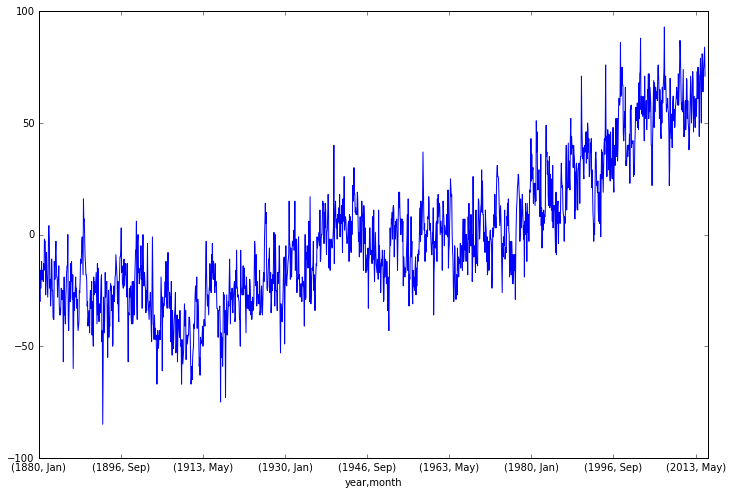

In [87]:
giss_temp_series.plot(figsize=LARGE_FIGSIZE)

To improve on this, let's reuse an index we generated above with `date_range`:

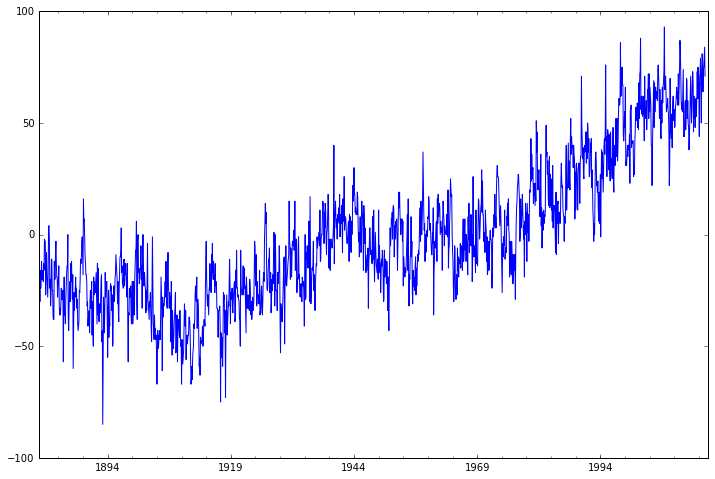

In [88]:
giss_temp_series.index = giss_temp_index
giss_temp_series.plot(figsize=LARGE_FIGSIZE)

## 8. Statistical analysis

### Descriptive statistics

Let's go back to the dataframe version of the GISS temperature dataset temporarily to analyze anomalies month per month. Like most functions on a dataframe, **stats functions are computed column per column**. They also ignore missing values:

In [90]:
giss_temp

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1880,-34.0,-27.0,-22.0,-30.0,-16.0,-24.0,-19.0,-12.0,-20.0,-19.0,-16.0,-21.0
1881,-13.0,-16.0,-2.0,-3.0,-3.0,-27.0,-12.0,-8.0,-18.0,-23.0,-28.0,-18.0
1882,3.0,4.0,-2.0,-24.0,-20.0,-32.0,-27.0,-11.0,-11.0,-25.0,-25.0,-37.0
1883,-38.0,-38.0,-12.0,-20.0,-20.0,-8.0,-3.0,-13.0,-19.0,-19.0,-28.0,-21.0
1884,-20.0,-14.0,-31.0,-36.0,-33.0,-36.0,-31.0,-24.0,-29.0,-25.0,-29.0,-25.0
1885,-57.0,-29.0,-19.0,-36.0,-35.0,-40.0,-28.0,-24.0,-17.0,-14.0,-14.0,0.0
1886,-37.0,-43.0,-34.0,-23.0,-21.0,-30.0,-13.0,-21.0,-12.0,-22.0,-29.0,-18.0
1887,-60.0,-43.0,-26.0,-34.0,-28.0,-25.0,-19.0,-28.0,-24.0,-33.0,-29.0,-40.0
...,...,...,...,...,...,...,...,...,...,...,...,...


In [91]:
monthly_averages = giss_temp.mean()
monthly_averages

Jan   -1.411765
Feb   -0.161765
Mar    1.294118
Apr   -0.823529
May   -2.051852
Jun   -3.237037
Jul   -0.688889
Aug   -0.622222
Sep    0.755556
Oct    1.333333
Nov    0.148148
Dec   -2.274074
dtype: float32

It is possible to apply stats functions across rows instead of columns using the `axis` keyword (just like in NumPy).

In [92]:
yearly_averages = giss_temp.mean(axis=1)
yearly_averages

Year
1880   -21.666666
1881   -14.250000
1882   -17.250000
1883   -19.916666
1884   -27.750000
1885   -26.083334
1886   -25.250000
1887   -32.416668
          ...    
2008    48.916668
2009    59.166668
2010    66.166664
2011    54.666668
2012    57.250000
2013    60.250000
2014    68.083336
2015    77.500000
dtype: float32

`describe` provides many descriptive stats computed at once:

In [93]:
mean_sea_level.describe()

/Users/dbalduini/anaconda/envs/ml-env-py3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,northern_hem,southern_hem,mean_global
count,869.000000,869.000000,780.000000
mean,25.507298,28.730510,29.166036
std,29.555314,24.829111,21.226033
min,-38.377000,-28.239000,-11.796000
25%,4.119000,8.984000,NaN
50%,24.781000,28.283000,NaN
75%,47.391000,46.670000,NaN
max,99.108000,90.633000,75.007000


### Rolling statistics

Let's remove high frequency signal and extract the trend:

In [95]:
full_globe_temp.rolling?

Rolling [window=10,center=False,axis=0]


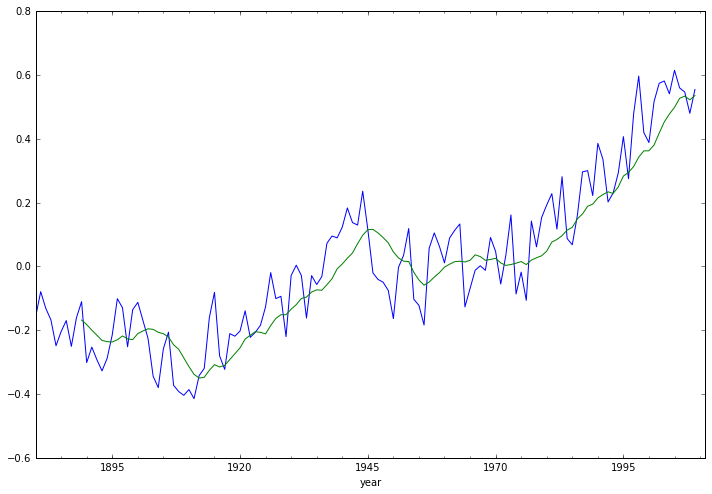

In [94]:
full_globe_temp.plot()
rolled_series = full_globe_temp.rolling(window=10, center=False)
print(rolled_series)
rolled_series.mean().plot(figsize=LARGE_FIGSIZE)

In [ ]:
# To see what all can be done while rolling, 
#pd.rolling_<TAB>

### Describing categorical series

Let's look at our `local_sea_level_stations` dataset some more:

In [96]:
local_sea_level_stations.describe()

/Users/dbalduini/anaconda/envs/ml-env-py3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,ID,Lat,Lon,GLOSS ID,Coastline,Station
count,1486.000000,1486.000000,1486.000000,282.000000,1486.000000,1486.000000
mean,1081.965007,28.118837,22.453178,165.606383,533.837820,86.109690
std,663.060089,30.853085,93.165553,95.258579,311.994893,119.490775
min,1.000000,-77.850000,-179.367000,3.000000,10.000000,1.000000
25%,522.250000,13.150000,-64.745500,NaN,220.000000,12.250000
50%,1031.500000,35.606000,14.490500,NaN,641.500000,41.000000
75%,1640.750000,49.233000,118.716500,NaN,822.000000,101.000000
max,2320.000000,82.490000,179.217000,351.000000,999.000000,725.000000


`.describe()` only displays information about continuous `Series`. What about categorical ones?

In [97]:
local_sea_level_stations.columns

Index(['Station Name', 'ID', 'Lat', 'Lon', 'GLOSS ID', 'Country', 'Date',
       'Coastline', 'Station'],
      dtype='object')

In [98]:
local_sea_level_stations["Country"]

0       ALA
1       ALA
2       ALA
3       ALA
4       ASM
5       ATA
6       ATA
7       ATA
       ... 
1478    VNM
1479    VNM
1480    VNM
1481    VIR
1482    VIR
1483    VIR
1484    VIR
1485    YEM
Name: Country, dtype: object

In [99]:
local_sea_level_stations["Country"].describe()

count     1486
unique     135
top        USA
freq       178
Name: Country, dtype: object

In [100]:
# List of unique values:
local_sea_level_stations["Country"].unique()

array(['ALA', 'ASM', 'ATA', 'ARG', 'AUS', 'BHS', 'BHR', 'BGD', 'BEL',
       'BMU', 'BRA', 'IOT', 'BGR', 'CAN', 'CPV', 'CYM', 'CHL', 'CHN',
       'CCK', 'COL', 'COG', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CYP',
       'DNK', 'DOM', 'ECU', 'EGY', 'SLV', 'EST', 'FLK', 'FRO', 'FJI',
       'FIN', 'FRA', 'GUF', 'PYF', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC',
       'GRD', 'GLP', 'GUM', 'GTM', 'HTI', 'HND', 'HKG', 'ISL', 'IND',
       'IDN', 'IRN', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY',
       'KEN', 'KIR', 'PRK', 'KOR', 'LVA', 'LTU', 'MAC', 'MDG', 'MYS',
       'MDV', 'MLT', 'MHL', 'MTQ', 'MUS', 'MYT', 'MEX', 'FSM', 'MCO',
       'MNE', 'MAR', 'MOZ', 'MMR', 'NAM', 'NRU', 'NLD', 'NCL', 'NZL',
       'NGA', 'MNP', 'NOR', 'OMN', 'PAK', 'PLW', 'PAN', 'PNG', 'PER',
       'PHL', 'POL', 'PRT', 'PRI', 'REU', 'ROU', 'RUS', 'SHN', 'WSM',
       'SEN', 'SYC', 'SGP', 'SVN', 'SLB', 'ZAF', 'ESP', 'SDN', 'SJM',
       'SWE', 'TWN', 'TZA', 'THA', 'TON', 'TTO', 'TUR', 'TUV', 'UKR',
       'GBR', 'USA',

In [101]:
local_sea_level_stations["Country"].value_counts()

USA    178
JPN    139
AUS     93
RUS     86
CAN     82
GBR     70
ESP     61
ITA     44
      ... 
SYC      1
VUT      1
MDG      1
MAR      1
CIV      1
MAC      1
GIB      1
UKR      1
Name: Country, dtype: int64

In [102]:
# To save memory, we can convert it to a categorical column:
local_sea_level_stations["Country"] = local_sea_level_stations["Country"].astype("category")

We can also create categorical series from continuous ones with the cut function:

In [103]:
categorized = pd.cut(full_globe_temp, 3, labels=["L", "M", "H"])
categorized

year
1880      L
1881      L
1882      L
1883      L
1884      L
1885      L
1886      L
1887      L
       ... 
2004      H
2005      H
2006      H
2007      H
2008      H
2009      H
2010    NaN
2011    NaN
Freq: A-DEC, Name: mean temp, dtype: category
Categories (3, object): [L < M < H]

In [104]:
# The advantage is that we can use labels and control the order they should be treated in (L < M < H)
categorized.cat.categories

Index(['L', 'M', 'H'], dtype='object')

**QUIZ:** How much memory did we save? What if it was categorized but with dtype `object` instead of `category`?

## 9. Data Aggregation/summarization

Now that we have a good grasp on our datasets, Let's transform and analyze them some more to prepare them to compare them. The 2 function(alities)s to learn about here are `groupby` and `pivot_table`.

### GroupBy

Let's explore the sea levels, first splitting into calendar years to compute average sea levels for each year:

In [105]:
mean_sea_level

,northern_hem,southern_hem,mean_global
date,,,
1992.9323,13.717,2.517,NaN
1992.9595,1.328,-7.645,-5.818
1992.9866,-13.375,-2.267,-7.525
1993.0138,-24.723,0.855,-9.215
1993.0409,-29.231,-2.020,-11.796
1993.0681,-32.538,-0.398,-11.291
1993.0952,-35.588,4.102,-9.569
1993.1223,-26.579,6.787,-3.714
...,...,...,...


In [106]:
mean_sea_level = mean_sea_level.reset_index()
mean_sea_level

,date,northern_hem,southern_hem,mean_global
0,1992.9323,13.717,2.517,NaN
1,1992.9595,1.328,-7.645,-5.818
2,1992.9866,-13.375,-2.267,-7.525
3,1993.0138,-24.723,0.855,-9.215
4,1993.0409,-29.231,-2.020,-11.796
5,1993.0681,-32.538,-0.398,-11.291
6,1993.0952,-35.588,4.102,-9.569
7,1993.1223,-26.579,6.787,-3.714
...,...,...,...,...
861,2016.3611,56.282,66.331,NaN


In [107]:
# Groupby with pandas can be done on a column or by applying a custom function to the index. 
# If we want to group the data by year, we can build a year column into the DF:
mean_sea_level["year"] = mean_sea_level["date"].apply(int)
mean_sea_level

,date,northern_hem,southern_hem,mean_global,year
0,1992.9323,13.717,2.517,NaN,1992
1,1992.9595,1.328,-7.645,-5.818,1992
2,1992.9866,-13.375,-2.267,-7.525,1992
3,1993.0138,-24.723,0.855,-9.215,1993
4,1993.0409,-29.231,-2.020,-11.796,1993
5,1993.0681,-32.538,-0.398,-11.291,1993
6,1993.0952,-35.588,4.102,-9.569,1993
7,1993.1223,-26.579,6.787,-3.714,1993
...,...,...,...,...,...
861,2016.3611,56.282,66.331,NaN,2016


In [108]:
sl_grouped_year = mean_sea_level.groupby("year")

What kind of object did we create?

In [109]:
type(sl_grouped_year)

pandas.core.groupby.DataFrameGroupBy

What to do with that strange GroupBy object? We can first loop over it to get the labels and the sub-dataframes for each group:

In [110]:
for group_name, subdf in sl_grouped_year:
    print(group_name)
    print(subdf)
    print("")

1992
        date  northern_hem  southern_hem  mean_global  year
0  1992.9323        13.717         2.517          NaN  1992
1  1992.9595         1.328        -7.645       -5.818  1992
2  1992.9866       -13.375        -2.267       -7.525  1992

1993
         date  northern_hem  southern_hem  mean_global  year
3   1993.0138       -24.723         0.855       -9.215  1993
4   1993.0409       -29.231        -2.020      -11.796  1993
5   1993.0681       -32.538        -0.398      -11.291  1993
6   1993.0952       -35.588         4.102       -9.569  1993
7   1993.1223       -26.579         6.787       -3.714  1993
8   1993.1495       -29.622        10.315       -2.471  1993
9   1993.1766       -34.527         5.919       -6.784  1993
10  1993.2038       -34.250         7.193       -5.772  1993
..        ...           ...           ...          ...   ...
32  1993.8010        30.541       -14.024       -1.886  1993
33  1993.8282        18.240       -14.008          NaN  1993
34  1993.8553    

We could have done the same with less effort by grouping by the result of a custom function applied to the index. Let's reset the dataframe:

In [114]:
mean_sea_level = mean_sea_level.drop(["year"], axis=1).set_index("date")

So that we can do the groupby on the index:

In [115]:
sl_grouped_year = mean_sea_level.groupby(int)

Something else that can be done with such an object is to look at its `groups` attribute to see the labels mapped to the rows involved:

In [116]:
sl_grouped_year.groups

{1992: [1992.9323, 1992.9595, 1992.9866],
 1993: [1993.0138,
  1993.0409,
  1993.0681,
  1993.0952,
  1993.1223,
  1993.1495,
  1993.1766,
  1993.2038,
  1993.2309,
  1993.2581,
  1993.2852,
  1993.3124,
  1993.3395,
  1993.3667,
  1993.3938,
  1993.421,
  1993.4481,
  1993.4753,
  1993.5024,
  1993.5296,
  1993.5567,
  1993.5839,
  1993.611,
  1993.6382,
  1993.6653,
  1993.6925,
  1993.7196,
  1993.7468,
  1993.7739,
  1993.801,
  1993.8282,
  1993.8553,
  1993.8825,
  1993.9096,
  1993.9368,
  1993.9639,
  1993.9911],
 1994: [1994.0182,
  1994.0454,
  1994.0725,
  1994.0997,
  1994.1268,
  1994.154,
  1994.1811,
  1994.2083,
  1994.2354,
  1994.2626,
  1994.2897,
  1994.3169,
  1994.344,
  1994.3712,
  1994.3983,
  1994.4255,
  1994.4526,
  1994.4798,
  1994.5069,
  1994.534,
  1994.5612,
  1994.5883,
  1994.6155,
  1994.6426,
  1994.6698,
  1994.6969,
  1994.7241,
  1994.7512,
  1994.7784,
  1994.8055,
  1994.8327,
  1994.8598,
  1994.887,
  1994.9141,
  1994.9413,
  1994.9684,
  1

How to aggregate the results of this grouping depends on what we want to see: do we want to see averaged over the years? That is so common that it has been implemented directly as a method on the `GroupBy` object.

In [117]:
sl_grouped_year.mean()

,northern_hem,southern_hem,mean_global
1992,0.556667,-2.465000,-6.671500
1993,-3.787108,-5.485378,-4.181882
1994,-4.631432,-3.523946,-3.668971
1995,-2.709314,-1.625171,-1.755452
1996,-1.184541,-0.204919,0.775912
1997,1.205108,8.180189,7.155545
1998,10.994865,4.420541,10.108182
1999,10.244595,8.327162,12.321727
...,...,...,...
2009,37.268270,43.703973,46.127108


In [118]:
# We can apply any other reduction function or even a dict of functions using aggregate:
sl_grouped_year.aggregate({"mean_global": np.std})

,mean_global
1992,1.207031
1993,3.411971
1994,3.347750
1995,3.486596
1996,3.138087
1997,5.444541
1998,3.565379
1999,2.960703
...,...
2009,3.776398


Another possibility is to transform each group separately, rather than aggregate. For example, here we group over decades and subtract to each value, the average over that decade:

In [119]:
sl_grouped_decade = mean_sea_level.groupby(lambda x: int(x/10.))
sl_grouped_decade.groups.keys()

dict_keys([200, 201, 199])

In [120]:
sl_grouped_decade.transform(lambda subframe: (subframe - subframe.mean()/subframe.std()))

,northern_hem,southern_hem,mean_global
date,,,
1992.9323,13.652814,2.395273,NaN
1992.9595,1.263814,-7.766727,-6.207707
1992.9866,-13.439186,-2.388727,-7.914707
1993.0138,-24.787186,0.733273,-9.604707
1993.0409,-29.295186,-2.141727,-12.185707
1993.0681,-32.602186,-0.519727,-11.680707
1993.0952,-35.652186,3.980273,-9.958707
1993.1223,-26.643186,6.665273,-4.103707
...,...,...,...


In [121]:
sl_grouped_decade.transform?

### Pivot_table

Pivot table also allows to summarize the information, allowing to convert repeating columns into axes. For example, let's say that we would like to know how many sea level stations are in various european countries. And we would like to group the answers into 2 categories: the stations that have been updated recently (after 2000) and the others. 

Let's first extract only entries located (roughly) in Europe.

In [123]:
european_filter = ((local_sea_level_stations["Lat"] > 30) & 
                   (local_sea_level_stations["Lat"] < 70) & 
                   (local_sea_level_stations["Lon"] > -10) & 
                   (local_sea_level_stations["Lon"] < 40) 
                   )

# Let's make a copy to work with a new, clean block of memory 
# (if you are interested, try and remove the copy to see the consequences further down...)
european_stations = local_sea_level_stations[european_filter].copy()
european_stations["Country"].unique()

[ALA, BEL, BGR, HRV, CYP, ..., ESP, SWE, TUR, UKR, GBR]
Length: 37
Categories (37, object): [ALA, BEL, BGR, HRV, ..., SWE, TUR, UKR, GBR]

The columns of our future table should have 2 values, whether the station was updated recently or not. Let's build a column to store that information:

In [124]:
european_stations["Recently updated"] = european_stations["Date"] > pd.to_datetime("2000")

Finally, what value will be displayed inside the table. The values should be extracted from a column, pivot_table allowing an aggregation function to be applied when more than 1 value is found for a given case. Each station should count for 1, and we could aggregate multiple stations by summing these ones:

In [125]:
european_stations["Number of stations"] = np.ones(len(european_stations))

In [126]:
european_stations.sort_values(by="Country")

,Station Name,ID,Lat,Lon,GLOSS ID,Country,Date,Coastline,Station,Recently updated,Number of stations
0,HELIGMAN,231,60.200,19.300,NaN,ALA,1980-01-01,60,251,False,1.0
1,KOBBAKLINTAR,63,60.033,19.883,NaN,ALA,1980-01-01,60,261,False,1.0
2,LEMSTROM,84,60.100,20.017,NaN,ALA,1980-01-01,60,271,False,1.0
3,FOGLO / DEGERBY,249,60.032,20.385,NaN,ALA,2015-06-10,60,281,True,1.0
128,ZEEBRUGGE,470,51.350,3.200,NaN,BEL,2016-07-26,160,11,True,1.0
129,OOSTENDE,413,51.233,2.917,NaN,BEL,2016-07-26,160,21,True,1.0
130,NIEUWPOORT,489,51.150,2.733,NaN,BEL,2016-07-26,160,31,True,1.0
146,BOURGAS,317,42.483,27.483,NaN,BGR,1997-08-27,295,21,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1211,ANTALYA II,1681,36.833,30.617,NaN,TUR,2013-09-07,310,52,True,1.0


In [127]:
station_counts = pd.pivot_table(european_stations, index="Country", columns="Recently updated", 
                                values="Number of stations", aggfunc=np.sum)
# Let's remove from the table the countries for which no station was found:
station_counts.dropna(how="all")

Recently updated,False,True
Country,,
ALA,3.0,1.0
BEL,NaN,3.0
BGR,2.0,NaN
CYP,1.0,1.0
DEU,NaN,9.0
DNK,1.0,14.0
EGY,1.0,1.0
ESP,7.0,38.0
...,...,...


**QUIZ:** Why is there still some countries with no entries?

**EXERCISE:** How many recently updated stations? Not recently updated stations? Which country has the most recently updated stations? 

Bonus: Which country has the most stations?

In [ ]:
# Your code here

**EXERCISE:** How would we build the same dataframe with a `groupby` operation?

In [ ]:
# Your code here

## 10. Correlations and regressions

### Correlation coefficients

Both Series and dataframes have a `corr` method to compute the correlation coefficient between series:

In [128]:
# Let's see what how the various sea levels are correlated with each other:
mean_sea_level["northern_hem"].corr(mean_sea_level["southern_hem"])

0.36048187747206756

In [129]:
# If series are already grouped into a DataFrame, computing all correlation coeff is trivial:
mean_sea_level.corr()

,northern_hem,southern_hem,mean_global
northern_hem,1.000000,0.360482,0.649231
southern_hem,0.360482,1.000000,0.896886
mean_global,0.649231,0.896886,1.000000


Note: by default, the method used is the `Pearson` correlation coefficient (https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient). Other methods are available (`kendall`, `spearman` using the `method` kwarg).

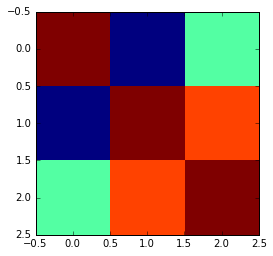

In [130]:
# Visualize the correlation matrix
plt.imshow(mean_sea_level.corr(), interpolation="nearest")

In [131]:
plt.yticks?

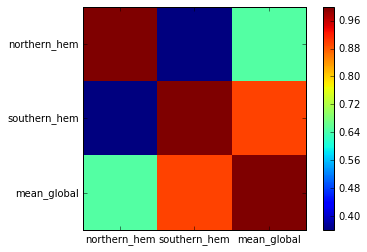

In [132]:
# let's make it a little better to confirm that learning about global sea level cannot be done from just 
# looking at stations in the northern hemisphere:
plt.imshow(mean_sea_level.corr(), interpolation="nearest")
plt.xticks(np.arange(3), mean_sea_level.corr().columns)
plt.yticks(np.arange(3), mean_sea_level.corr().index)
plt.colorbar()

### OLS

The recommeded way to build ordinaty least square regressions is by using `statsmodels`.

In [133]:
import statsmodels.formula.api as sm

In [134]:
sm_model = sm.ols(formula="mean_global ~ northern_hem + southern_hem", data=mean_sea_level).fit()

In [135]:
sm_model.params

Intercept       1.468349
northern_hem    0.333625
southern_hem    0.735599
dtype: float64

In [136]:
type(sm_model.params)

pandas.core.series.Series

In [137]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            mean_global   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 3.188e+04
Date:                Fri, 30 Dec 2016   Prob (F-statistic):               0.00
Time:                        19:36:54   Log-Likelihood:                -1765.7
No. Observations:                 780   AIC:                             3537.
Df Residuals:                     777   BIC:                             3551.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        1.4683      0.138     10.651      0.000         1.198     1.739
northern_hem     0.3336      0.003    108.839      0.000         0.328     0.340
southern_hem     0.7356      0.004    191.198      0.000         0.728     0.743
==============================================================================
Omnibus:                       86.727   Durbin-Watson:                   0.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.349
Skew:                           0.206   Prob(JB):                     4.24e-07
Kurtosis:                       2.144   Cond. No.                         75.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

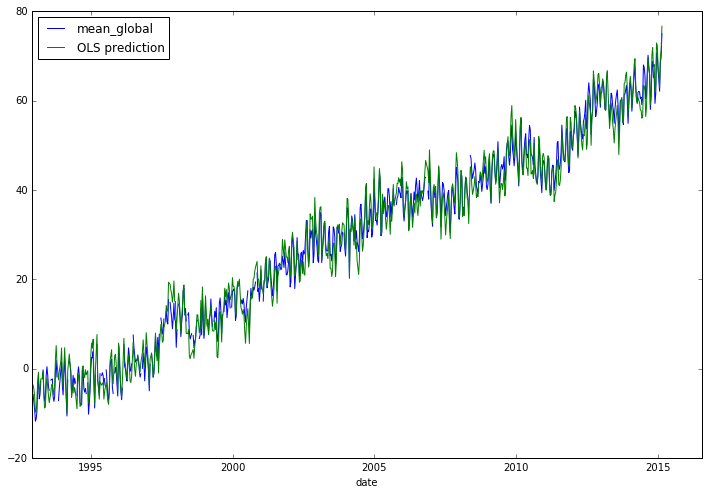

In [138]:
plt.figure(figsize=LARGE_FIGSIZE)
mean_sea_level["mean_global"].plot()
sm_model.fittedvalues.plot(label="OLS prediction")
plt.legend(loc="upper left")

### An interlude: data alignment

#### Converting the floating point date to a timestamp

Now, we would like to look for correlations between our monthly temperatures and the sea levels we have. For this to be possible, some data alignment must be done since the time scales are very different for the 2 datasets. 

In [139]:
mean_sea_level["mean_global"].index

Float64Index([1992.9323, 1992.9595, 1992.9866, 1993.0138, 1993.0409, 1993.0681,
              1993.0952, 1993.1223, 1993.1495, 1993.1766,
              ...
              2016.3068,  2016.334, 2016.3611, 2016.3883, 2016.4154, 2016.4426,
              2016.4697, 2016.4969,  2016.524, 2016.5512],
             dtype='float64', name='date', length=869)

In [140]:
giss_temp_series.index

PeriodIndex(['1880-01', '1880-02', '1880-03', '1880-04', '1880-05', '1880-06',
             '1880-07', '1880-08', '1880-09', '1880-10',
             ...
             '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08',
             '2015-09', '2015-10', '2015-11', '2015-12'],
            dtype='int64', length=1632, freq='M')

In [141]:
DAYS_PER_YEAR = {}

In [142]:
import calendar
# Let's first convert the floating point dates in the sea level to timestamps:
def floating_year_to_timestamp(float_date):
    """ Convert a date as a floating point year number to a pandas timestamp object.
    """
    year = int(float_date)
    days_per_year = 366 if calendar.isleap(year) else 365
    remainder = float_date - year
    daynum = 1 + remainder * (days_per_year - 1)
    daynum = int(round(daynum))
    # Convert day number to month and day
    day = daynum
    month = 1
    while month < 13:
        month_days = calendar.monthrange(year, month)[1]
        if day <= month_days:
            return pd.Timestamp(str(year)+"/"+str(month)+"/"+str(day))
        day -= month_days
        month += 1
    raise ValueError('{} does not have {} days'.format(year, daynum))

In [143]:
floating_year_to_timestamp(1996.0), floating_year_to_timestamp(1996.5), floating_year_to_timestamp(1996.9999)

(Timestamp('1996-01-01 00:00:00'),
 Timestamp('1996-07-02 00:00:00'),
 Timestamp('1996-12-31 00:00:00'))

In [144]:
dt_index = pd.Series(mean_sea_level["mean_global"].index).apply(floating_year_to_timestamp)
dt_index

0     1992-12-06
1     1992-12-16
2     1992-12-26
3     1993-01-06
4     1993-01-16
5     1993-01-26
6     1993-02-05
7     1993-02-15
         ...    
861   2016-05-12
862   2016-05-22
863   2016-06-01
864   2016-06-11
865   2016-06-20
866   2016-06-30
867   2016-07-10
868   2016-07-20
Name: date, dtype: datetime64[ns]

In [145]:
mean_sea_level = mean_sea_level.reset_index(drop=True)
mean_sea_level.index = dt_index
mean_sea_level

,northern_hem,southern_hem,mean_global
date,,,
1992-12-06,13.717,2.517,NaN
1992-12-16,1.328,-7.645,-5.818
1992-12-26,-13.375,-2.267,-7.525
1993-01-06,-24.723,0.855,-9.215
1993-01-16,-29.231,-2.020,-11.796
1993-01-26,-32.538,-0.398,-11.291
1993-02-05,-35.588,4.102,-9.569
1993-02-15,-26.579,6.787,-3.714
...,...,...,...


Now, how to align the 2 series? Is this one sampled regularly so that the month temperatures can be upscaled to that frequency?

#### Computing the difference between successive values

What is the frequency of that new index?

In [146]:
dt_index.dtype

dtype('<M8[ns]')

In [147]:
# What is the frequency of the new index? The numpy way to compute differences between all values doesn't work:
dt_index[1:] - dt_index[:-1]

0        NaT
1     0 days
2     0 days
3     0 days
4     0 days
5     0 days
6     0 days
7     0 days
       ...  
861   0 days
862   0 days
863   0 days
864   0 days
865   0 days
866   0 days
867   0 days
868      NaT
Name: date, dtype: timedelta64[ns]

**IMPORTANT Note:** The above failure is due to the fact that operations between series automatically align them based on their index.

In [148]:
# There is a method for shifting values up/down the index:
dt_index.shift()

0            NaT
1     1992-12-06
2     1992-12-16
3     1992-12-26
4     1993-01-06
5     1993-01-16
6     1993-01-26
7     1993-02-05
         ...    
861   2016-05-02
862   2016-05-12
863   2016-05-22
864   2016-06-01
865   2016-06-11
866   2016-06-20
867   2016-06-30
868   2016-07-10
Name: date, dtype: datetime64[ns]

In [149]:
# So the distances can be computed with 
dt_index - dt_index.shift()

0         NaT
1     10 days
2     10 days
3     11 days
4     10 days
5     10 days
6     10 days
7     10 days
        ...  
861   10 days
862   10 days
863   10 days
864   10 days
865    9 days
866   10 days
867   10 days
868   10 days
Name: date, dtype: timedelta64[ns]

In [150]:
# Not constant reads apparently. Let's downscale the frequency of the sea levels 
# to monthly, like the temperature reads we have:
monthly_mean_sea_level = mean_sea_level.resample("MS").mean().to_period()
monthly_mean_sea_level

,northern_hem,southern_hem,mean_global
date,,,
1992-12,0.556667,-2.465000,-6.671500
1993-01,-28.830667,-0.521000,-10.767333
1993-02,-30.596333,7.068000,-5.251333
1993-03,-32.431667,6.967000,-5.136333
1993-04,-23.668000,1.549667,-1.118000
1993-05,-21.731333,-2.863000,-6.319667
1993-06,-4.644333,-4.418000,-0.902333
1993-07,0.172667,-12.684667,-4.508000
...,...,...,...


In [151]:
monthly_mean_sea_level["mean_global"].align(giss_temp_series)

(1880-01   NaN
 1880-02   NaN
 1880-03   NaN
 1880-04   NaN
 1880-05   NaN
 1880-06   NaN
 1880-07   NaN
 1880-08   NaN
            ..
 2015-12   NaN
 2016-01   NaN
 2016-02   NaN
 2016-03   NaN
 2016-04   NaN
 2016-05   NaN
 2016-06   NaN
 2016-07   NaN
 Freq: M, Name: mean_global, dtype: float64, 1880-01   -34.0
 1880-02   -27.0
 1880-03   -22.0
 1880-04   -30.0
 1880-05   -16.0
 1880-06   -24.0
 1880-07   -19.0
 1880-08   -12.0
            ... 
 2015-12     NaN
 2016-01     NaN
 2016-02     NaN
 2016-03     NaN
 2016-04     NaN
 2016-05     NaN
 2016-06     NaN
 2016-07     NaN
 Freq: M, Name: Temp anomaly, dtype: float32)

In [152]:
giss_temp_series.align?

In [153]:
# Now that the series are using the same type and frequency of indexes, to align them is trivial:
monthly_mean_sea_level["mean_global"].align(giss_temp_series, join='inner')

(1992-12    -6.671500
 1993-01   -10.767333
 1993-02    -5.251333
 1993-03    -5.136333
 1993-04    -1.118000
 1993-05    -6.319667
 1993-06    -0.902333
 1993-07    -4.508000
              ...    
 2015-05          NaN
 2015-06          NaN
 2015-07          NaN
 2015-08          NaN
 2015-09          NaN
 2015-10          NaN
 2015-11          NaN
 2015-12          NaN
 Freq: M, Name: mean_global, dtype: float64, 1992-12    18.0
 1993-01    34.0
 1993-02    37.0
 1993-03    33.0
 1993-04    22.0
 1993-05    23.0
 1993-06    19.0
 1993-07    24.0
            ... 
 2015-05     NaN
 2015-06     NaN
 2015-07     NaN
 2015-08     NaN
 2015-09     NaN
 2015-10     NaN
 2015-11     NaN
 2015-12     NaN
 Freq: M, Name: Temp anomaly, dtype: float32)

In [154]:
aligned_sl, aligned_temp = monthly_mean_sea_level["mean_global"].align(giss_temp_series, join='inner')
aligned_df = pd.DataFrame({"mean_sea_level": aligned_sl, "mean_global_temp": aligned_temp})

The alignment can even be done on an entire dataframe:

In [155]:
monthly_mean_sea_level.align(giss_temp_series, axis=0, join='inner')

(         northern_hem  southern_hem  mean_global
 1992-12      0.556667     -2.465000    -6.671500
 1993-01    -28.830667     -0.521000   -10.767333
 1993-02    -30.596333      7.068000    -5.251333
 1993-03    -32.431667      6.967000    -5.136333
 1993-04    -23.668000      1.549667    -1.118000
 1993-05    -21.731333     -2.863000    -6.319667
 1993-06     -4.644333     -4.418000    -0.902333
 1993-07      0.172667    -12.684667    -4.508000
 ...               ...           ...          ...
 2015-05     43.444000     71.664750          NaN
 2015-06     59.716000     71.828667          NaN
 2015-07     72.460667     60.819000          NaN
 2015-08     89.157000     62.902000          NaN
 2015-09     93.290333     61.620333          NaN
 2015-10     96.100667     70.860667          NaN
 2015-11     79.575667     71.419000          NaN
 2015-12     68.749000     77.260667          NaN
 
 [277 rows x 3 columns], 1992-12    18.0
 1993-01    34.0
 1993-02    37.0
 1993-03    33.0
 1993-

In [156]:
aligned_sea_levels, aligned_temp = monthly_mean_sea_level.align(giss_temp_series, axis=0, join='inner')
aligned_monthly_data = aligned_sea_levels.copy()
aligned_monthly_data["global_temp"] = aligned_temp
aligned_monthly_data

,northern_hem,southern_hem,mean_global,global_temp
1992-12,0.556667,-2.465000,-6.671500,18.0
1993-01,-28.830667,-0.521000,-10.767333,34.0
1993-02,-30.596333,7.068000,-5.251333,37.0
1993-03,-32.431667,6.967000,-5.136333,33.0
1993-04,-23.668000,1.549667,-1.118000,22.0
1993-05,-21.731333,-2.863000,-6.319667,23.0
1993-06,-4.644333,-4.418000,-0.902333,19.0
1993-07,0.172667,-12.684667,-4.508000,24.0
...,...,...,...,...
2015-05,43.444000,71.664750,NaN,NaN


### Correlations between sea levels and temperatures

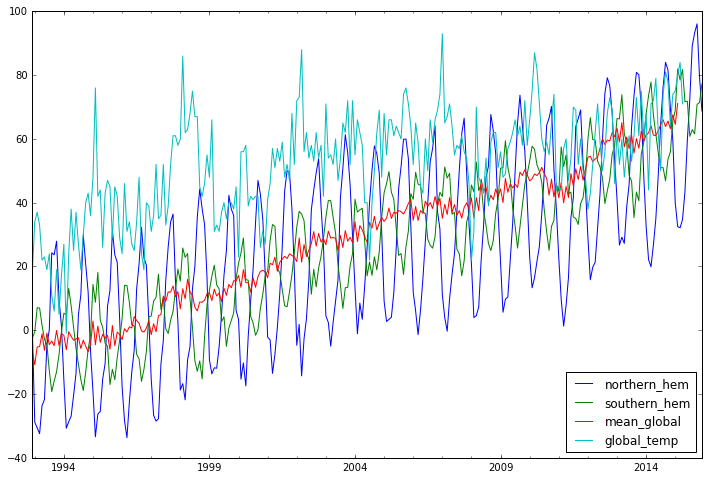

In [157]:
aligned_monthly_data.plot(figsize=LARGE_FIGSIZE)

In [158]:
aligned_monthly_data.corr()

,northern_hem,southern_hem,mean_global,global_temp
northern_hem,1.000000,0.349101,0.658666,0.378089
southern_hem,0.349101,1.000000,0.901072,0.597901
mean_global,0.658666,0.901072,1.000000,0.620717
global_temp,0.378089,0.597901,0.620717,1.000000


In [159]:
model = sm.ols("southern_hem ~ global_temp", data=aligned_monthly_data)
params = model.fit()
params.rsquared

0.35748527157977117

What if we had done the analysis yearly instead of monthly to remove seasonal variations?

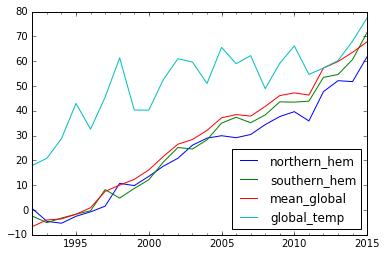

In [160]:
aligned_yearly_data = aligned_monthly_data.resample("A").mean()
aligned_yearly_data.plot()

In [161]:
aligned_yearly_data.corr()

,northern_hem,southern_hem,mean_global,global_temp
northern_hem,1.000000,0.989688,0.992187,0.821351
southern_hem,0.989688,1.000000,0.994649,0.820091
mean_global,0.992187,0.994649,1.000000,0.832198
global_temp,0.821351,0.820091,0.832198,1.000000


In [162]:
model = sm.ols("southern_hem ~ global_temp", data=aligned_yearly_data).fit()
model.rsquared

0.6725492407603153

## 11. Predictions from auto regression models

An auto-regresssive model fits existing data and build a (potentially predictive) model of the data fitted. We use the timeseries analysis (`tsa`) submodule of `statsmodels` to make out-of-sample predictions for the upcoming decades:

In [163]:
from statsmodels.tsa.api import AR

In [164]:
import statsmodels as sm
# Let's remove seasonal variations by resampling annually
data = giss_temp_series.resample("A").mean().to_timestamp()
ar_model = AR(data, freq='A')
ar_res = ar_model.fit(maxlag=60, disp=True)

/Users/dbalduini/anaconda/envs/ml-env-py3/lib/python3.5/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


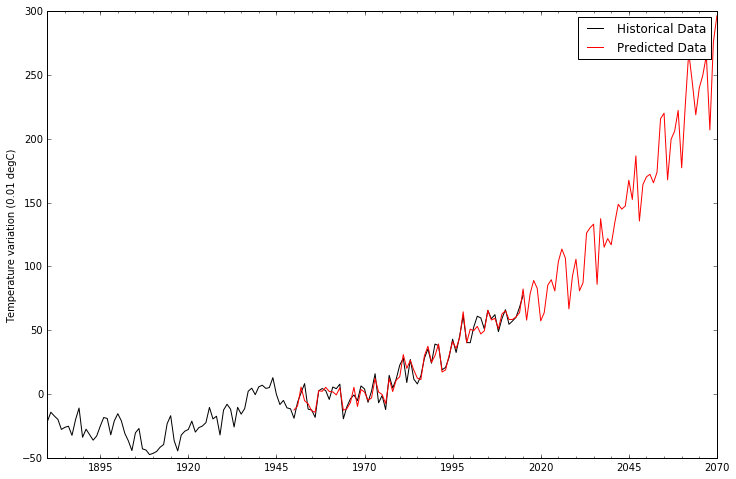

In [165]:
plt.figure(figsize=LARGE_FIGSIZE)
pred = ar_res.predict(start='1950-1-1', end='2070')
data.plot(style='k', label="Historical Data")
pred.plot(style='r', label="Predicted Data")
plt.ylabel("Temperature variation (0.01 degC)")
plt.legend()

**EXERCISE:** Make another auto-regression on the sea level of the Atlantic ocean to estimate how much New York is going to flood in the coming century. 

1. You can find the historical sea levels of the Atlantic ocean at http://sealevel.colorado.edu/files/current/sl_Atlantic_Ocean.txt or locally in `data/sea_levels/sl_Atlantic_Ocean.txt`. 
2. A little more work but more precise: extract the ID of a station in NewYork from the `local_sea_level_stations` dataset, and use it to download timeseries in NY (URL would be http://www.psmsl.org/data/obtaining/met.monthly.data/< ID >.metdata).

In [166]:
# Your code here